## Adversarial examples

In [1]:
from keras.applications.vgg16 import VGG16, decode_predictions 
from keras.applications.vgg16 import preprocess_input as preprocess_input_VGG16

from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as preprocess_input_VGG19

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as preprocess_input_inceptionv3


from keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm_notebook as pb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

%matplotlib inline

Using TensorFlow backend.


In [2]:
classes = open('/home/patbaa/.keras/models/imagenet_class_index.json').read()
classDF = pd.DataFrame(json.loads(classes)).T.reset_index()
classDF.pop(0);
classDF.columns = ['index', 'className']

### Let's use pre-trained (on ImageNet) VGG16 network  

In [3]:
vgg16_model = VGG16()

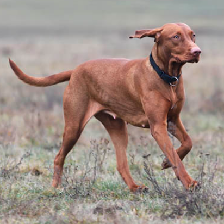

In [4]:
load_img('vizsla.png', target_size=(224, 224))

In [5]:
vizsla = load_img('vizsla.png', target_size=(224, 224))
vizsla = img_to_array(vizsla).reshape(1, 224, 224, 3)

In [77]:
decode_predictions(vgg16_model.predict(preprocess_input_VGG16(vizsla.copy())), 10)

[[('n02100583', 'vizsla', 0.92038995),
  ('n02087394', 'Rhodesian_ridgeback', 0.075894818),
  ('n02090379', 'redbone', 0.001459306),
  ('n02092339', 'Weimaraner', 0.0011551736),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.00026822742),
  ('n02091244', 'Ibizan_hound', 0.00026417221),
  ('n02107142', 'Doberman', 0.00015156221),
  ('n02093428', 'American_Staffordshire_terrier', 8.7028217e-05),
  ('n02093991', 'Irish_terrier', 6.0273895e-05),
  ('n02099712', 'Labrador_retriever', 5.7270896e-05)]]

## Increase all pixel values one-by one and save it's affect on predictions!
Only one pixel is modified at a time.

In [9]:
batch_images = [] # predict for a batch is faster
pred_list    = [] # store all the predictions
epsilon      = 3  # to distorse the original image's pixel

for channel in pb(range(3)):
    for i in pb(range(224)):
        for j in range(224):
            tmp = vizsla.copy()
            tmp[0, i, j, channel] += epsilon
            tmp = preprocess_input_VGG16(tmp)
            batch_images.append(tmp[0])
            
            if(len(batch_images) == 64):
                pred_list = pred_list + list(vgg16_model.predict_on_batch(np.array(batch_images)))
                batch_images = []

In [10]:
def convert_category(new_category, mask_weight, model, image, preprocess_input, verbose=True):
    if(verbose):
        print('Original predictions:')
    original_pred = model.predict(preprocess_input(image.copy()))
    if(verbose):
        print_indecies(['vizsla', new_category], original_pred)
        print('')
    imagenet_index = int(classDF[classDF.className == new_category]['index'].tolist()[0])
    predictions   = np.array(pred_list)[:,imagenet_index]
    mask = np.zeros((1, 224, 224, 3))

    idx = 0
    for channel in range(3):
        for i in range(224):
            for j in range(224):
                if(predictions[idx] >  original_pred[0][imagenet_index]):
                    mask[0, i, j, channel] = 1
                if(predictions[idx] <  original_pred[0][imagenet_index]):
                    mask[0, i, j, channel] = -1
                idx += 1

    new_pred = model.predict(preprocess_input((image + mask_weight*mask).copy()))
    if(verbose):
        print('New predictions:')
        print_indecies(['vizsla', new_category], new_pred)
    return mask_weight*mask

In [11]:
def print_indecies(names, preds):
    for i in range(len(names)):
        print(names[i], '\t', 
              np.round(preds[0][int(classDF[classDF.className == names[i]]['index'].tolist()[0])], 6))

In [24]:
def plot_new_category(new_category, mask_weight, preprocess_input, image=vizsla, model=vgg16_model):
    plt.rcParams['figure.figsize'] = (15, 5)
    mask = convert_category(new_category, mask_weight=mask_weight, model=model, image=image, 
                            preprocess_input=preprocess_input)
    plt.subplot('131')
    plt.imshow(image[0]*255)
    plt.axis('off')

    plt.subplot('132')
    plt.imshow(mask[0])
    plt.axis('off')

    plt.subplot('133')
    plt.imshow(image[0]*255 + mask[0])
    plt.axis('off')
    
    plt.show()
    
    return decode_predictions(model.predict(preprocess_input(image + mask).copy()), 5)

Original predictions:
vizsla 	 0.92039
Rhodesian_ridgeback 	 0.075895

New predictions:
vizsla 	 0.006798
Rhodesian_ridgeback 	 0.982611


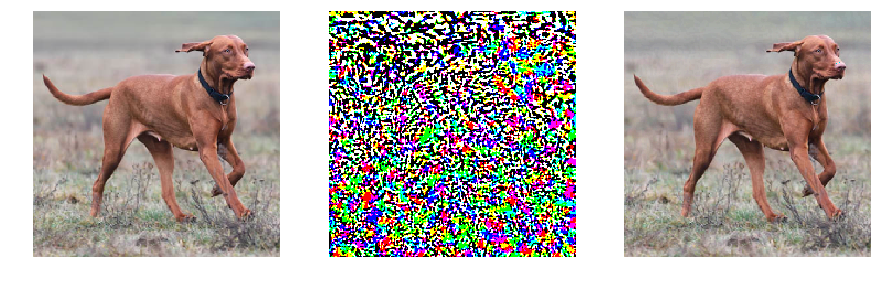

In [79]:
plot_new_category('Rhodesian_ridgeback', 2, preprocess_input=preprocess_input_VGG16)
ridgeback_mask = convert_category('Rhodesian_ridgeback', mask_weight=2, model=vgg16_model, image=vizsla, 
                              preprocess_input=preprocess_input_VGG16, verbose=False)
# afrikai oroszlánkutya

In [86]:
decode_predictions(vgg16_model.predict(preprocess_input_VGG16(ridgeback_mask.copy())), 10)
# töklámpás, giditális óra...

[[('n03590841', "jack-o'-lantern", 0.034056757),
  ('n03196217', 'digital_clock', 0.031387992),
  ('n03637318', 'lampshade', 0.030562973),
  ('n04286575', 'spotlight', 0.03048919),
  ('n03729826', 'matchstick', 0.025803071),
  ('n01930112', 'nematode', 0.023662651),
  ('n03666591', 'lighter', 0.022831935),
  ('n02948072', 'candle', 0.017316721),
  ('n04456115', 'torch', 0.010428985),
  ('n03759954', 'microphone', 0.010185608)]]

Original predictions:
vizsla 	 0.92039
Doberman 	 0.000152

New predictions:
vizsla 	 0.090959
Doberman 	 0.253415


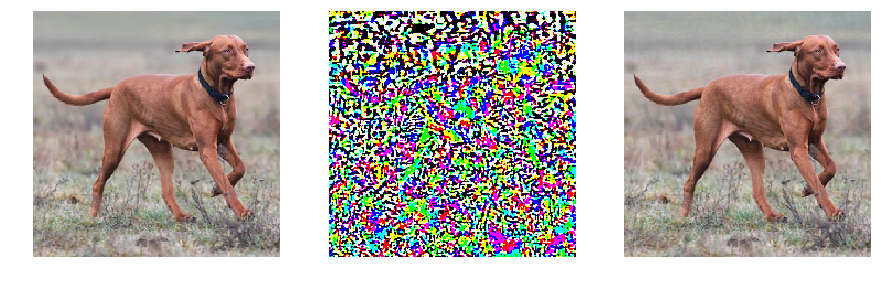

In [37]:
plot_new_category('Doberman', 2, preprocess_input=preprocess_input_VGG16)
doberman_mask = convert_category('Doberman', mask_weight=2, model=vgg16_model, image=vizsla, 
                              preprocess_input=preprocess_input_VGG16, verbose=False)

#### For an initially unlikely class this doesn't work. We need to go to 2nd, 3rd... derivate to have success. 

Original predictions:
vizsla 	 0.92039
iPod 	 0.0

New predictions:
vizsla 	 0.068122
iPod 	 0.000341


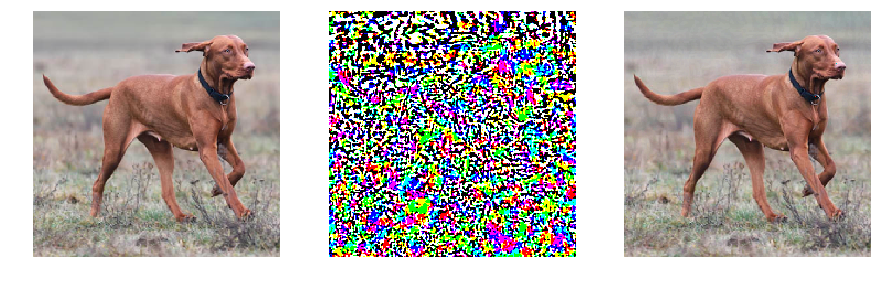

In [87]:
plot_new_category('iPod', 2, preprocess_input=preprocess_input_VGG16)
ipod_mask = convert_category('iPod', mask_weight=2, model=vgg16_model, image=vizsla, 
                              preprocess_input=preprocess_input_VGG16, verbose=False)

Original predictions:
vizsla 	 0.92039
go-kart 	 0.0

New predictions:
vizsla 	 0.024095
go-kart 	 0.0003


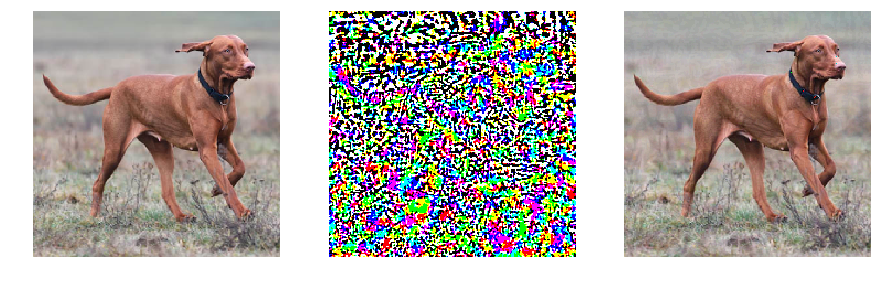

In [53]:
plot_new_category('go-kart', 3, preprocess_input=preprocess_input_VGG16)
gokart_mask = convert_category('go-kart', mask_weight=3, model=vgg16_model, image=vizsla, 
                              preprocess_input=preprocess_input_VGG16, verbose=False)

In [88]:
vgg19_model = VGG19()

In [89]:
decode_predictions(vgg19_model.predict(preprocess_input_VGG19(vizsla.copy())), top=5)

[[('n02100583', 'vizsla', 0.77393544),
  ('n02087394', 'Rhodesian_ridgeback', 0.22221379),
  ('n02090379', 'redbone', 0.0026647602),
  ('n02091244', 'Ibizan_hound', 0.00026868039),
  ('n02107142', 'Doberman', 0.0002519757)]]

In [92]:
decode_predictions(vgg19_model.predict(preprocess_input_VGG19((vizsla + 2*ridgeback_mask).copy())), top=5)

[[('n02087394', 'Rhodesian_ridgeback', 0.99329078),
  ('n02100583', 'vizsla', 0.0034417254),
  ('n02090379', 'redbone', 0.0022197387),
  ('n02109047', 'Great_Dane', 0.00038232896),
  ('n02093428', 'American_Staffordshire_terrier', 0.00023644877)]]

In [93]:
inceptionv3_model = InceptionV3()

In [94]:
decode_predictions(inceptionv3_model.predict(preprocess_input_inceptionv3(vizsla.copy())), top=5)

[[('n02100583', 'vizsla', 0.9949379),
  ('n02087394', 'Rhodesian_ridgeback', 0.0050590299),
  ('n02091244', 'Ibizan_hound', 2.0178363e-06),
  ('n02090379', 'redbone', 2.9518401e-07),
  ('n02092339', 'Weimaraner', 2.4371138e-07)]]

In [95]:
decode_predictions(inceptionv3_model.predict(preprocess_input_inceptionv3((vizsla + 2*ridgeback_mask).copy())), top=5)

[[('n02087394', 'Rhodesian_ridgeback', 0.99137563),
  ('n02100583', 'vizsla', 0.0085882768),
  ('n02090379', 'redbone', 2.9029321e-05),
  ('n02092339', 'Weimaraner', 3.2617586e-06),
  ('n02109047', 'Great_Dane', 8.552085e-07)]]

In [96]:
decode_predictions(inceptionv3_model.predict(preprocess_input_inceptionv3((vizsla + 2*doberman_mask).copy())), top=5)

[[('n02100583', 'vizsla', 0.66567975),
  ('n02087394', 'Rhodesian_ridgeback', 0.32711095),
  ('n02092339', 'Weimaraner', 0.0056474172),
  ('n02090379', 'redbone', 0.0011272248),
  ('n02093428', 'American_Staffordshire_terrier', 8.4829851e-05)]]

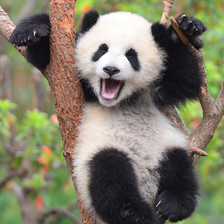

In [97]:
panda = load_img('panda.png', target_size=(224, 224))
panda = img_to_array(panda).reshape(1, 224, 224, 3)
load_img('panda.png', target_size=(224, 224))
# source: https://www.zoo-berlin.de/en/news/panda-blog/pictures/happy-birthday-meng-meng

In [98]:
decode_predictions(vgg16_model.predict(preprocess_input_VGG16(panda.copy())), top=5)

[[('n02510455', 'giant_panda', 0.97053033),
  ('n02500267', 'indri', 0.016698673),
  ('n02483362', 'gibbon', 0.0036366538),
  ('n02509815', 'lesser_panda', 0.0025006991),
  ('n02488702', 'colobus', 0.0015796729)]]

In [112]:
decode_predictions(vgg16_model.predict(preprocess_input_VGG16((panda + 8*ridgeback_mask).copy())), top=5)

[[('n02130308', 'cheetah', 0.2003437),
  ('n04399382', 'teddy', 0.12694103),
  ('n02510455', 'giant_panda', 0.11716057),
  ('n02509815', 'lesser_panda', 0.044037357),
  ('n02128925', 'jaguar', 0.03284635)]]

### The problem



### Can generalize across architectures:
##### VGG16
<img src="vgg16.png"></img>
[soure: http://file.scirp.org/Html/4-7800353_65406.htm]

##### Inception v3
<img src="inceptionv3.png"></img>
[soure: https://github.com/tensorflow/models/tree/master/research/inception]

Even they are different they are tend to solve the same problem so they may represent a similar function.

## Defense

 - Dropout in test time $\to$ the distribution of predictions can be informative if adversarial or not 
 - Synthesize adversarial examples and add them to the train set
 - Loss: $$\hat{J} = \alpha J(W, x, y) + (1-\alpha)J(W, x + adversarial mask,y)$$
 - zoom the picture (zoom-resistant adversarial pictures can be made too...)

## Adversarial train examples can lead to better performance

# Read more: 
 - https://blog.openai.com/adversarial-example-research/  
 - https://blog.openai.com/robust-adversarial-inputs/        